# Exploratory data analysis

In this notebook, we perform so some simple EDA on the data we are given. We have four main data sources pertaining to the candidate molecules that we can explore.

1. Targets:
It is useful to look at that target data itself, investigate imbalances, nullities etc.

2. Toxicophores:
The key question here is what the distributions are for the various target given the Dice similarity of known toxic scaffold molecules and our candidate molecules.

3. Molecular Descriptors:
Similar story to the toxocophores.

4. Fingerprint:
Here, we have consider clustering using KModes and consider how this separates the targets.

### 1. Imports

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

### 2. Collect data

In [83]:
source_data = 'data/data_dups_removed.csv'
source_data_wH = 'data/data_dups_removed_with_H.csv'
molecular_descriptors = 'data/molecular_descriptors_from_source.csv'
fingerprint = 'data/morgan_fingerprint_from_source_10.csv'
toxicophores = 'data/known_toxic.csv'

In [84]:
 source_data, source_data_wH, molecular_descriptors, fingerprint, toxicophores= \
[pd.read_csv(x, index_col = 0) for x in \
 [source_data, source_data_wH, molecular_descriptors, fingerprint, toxicophores]]

In [85]:
targets = ['SR-HSE','NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',\
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD']

target = source_data[targets]

### 3. Create some important functions

In [89]:
def counter_plot(target:pd.core.frame.DataFrame)->None:
    """
    Given a target dataframe, provides a historgram of the distribution of positive, negative and null columns.
    """
    count = {}
    for cols in target.columns:
        temp = target[cols].fillna('NAN') 
        count[cols] = temp.value_counts().to_dict()

    zeros = [count[t][0] for t in targets]
    ones = [count[t][1] for t in targets]
    nans = [count[t]['NAN'] for t in targets]

    fig = plt.figure(figsize = (15,10))
    ax = fig.add_subplot(111)
    width = 0.3
    rects1 = ax.bar(np.arange(12), zeros, width, color='r')
    rects2 = ax.bar(np.arange(12) + 0.3, ones, width, color='g')
    rects3 = ax.bar(np.arange(12)+ 2*0.3, nans, width, color='b')
    
    ind = np.arange(12)

    ax.set_ylabel('Amount')
    ax.set_xticks(ind+width)
    ax.set_xticklabels( targets, rotation=90) 
    ax.legend( (rects1[0], rects2[0], rects3[0]), ('Negative', 'Positive', 'NaN') )

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.grid()
    plt.plot()
    
def perc_of_pos(df:pd.core.frame.DataFrame)->pd.core.series.Series:
    """
    Yields a series object, givein the percentage of positive outcomes from the df.
    """
    return ((df == 1).sum(0)/len(df)).sort_values(ascending = False)

from scipy import stats
def box_plot_and_ks_test(col_name:str, data:pd.core.frame.DataFrame, \
                         targets:list = targets)->None:
    """
    Given a toxic molecule, provides a boxplot of toxic_mol against positive and negative target outcomes.
    Also, provides a scatter plot of the corresponding Kolmogorov-Smirnov 2 sample test.
    
    Recall : 
    If p is large (or statistic very low) then we cannot reject, 
    if p is low < 0.05 (or the stat very large) then we can.
    
    H_0 is that the two data samples come from the same distribution.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))
    fig.suptitle(col_name)
    

    
    
    negative = [data[col_name][target[tar] == 0] for tar in targets]
    positive = [data[col_name][target[tar] == 1] for tar in targets]

    bp_res_negative = ax1.boxplot(negative)
    bp_res_positive = ax2.boxplot(positive)

    ax1.set_xticklabels(targets,rotation = 'vertical');
    ax2.set_xticklabels(targets,rotation = 'vertical');

    test = [stats.ks_2samp(negative[i], positive[i]) for i in range(0,12)]
    test_result = np.array([[t.statistic, t.pvalue] for t in test])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

    ax1.scatter(np.arange(12),test_result[:,0])
    ax2.scatter(np.arange(12), test_result[:,1])
    #ax2.plot(np.arange(12), [0.05]*12, color = 'r')
    ax1.set_xticks(np.arange(12))
    ax2.set_xticks(np.arange(12))
    ax1.set_xticklabels(targets,rotation = 'vertical');
    ax2.set_xticklabels(targets,rotation = 'vertical');
    ax1.grid()
    ax2.grid()

# 4. Analysis

In this section, we finally provide some analysis

### 4a. Target analysis


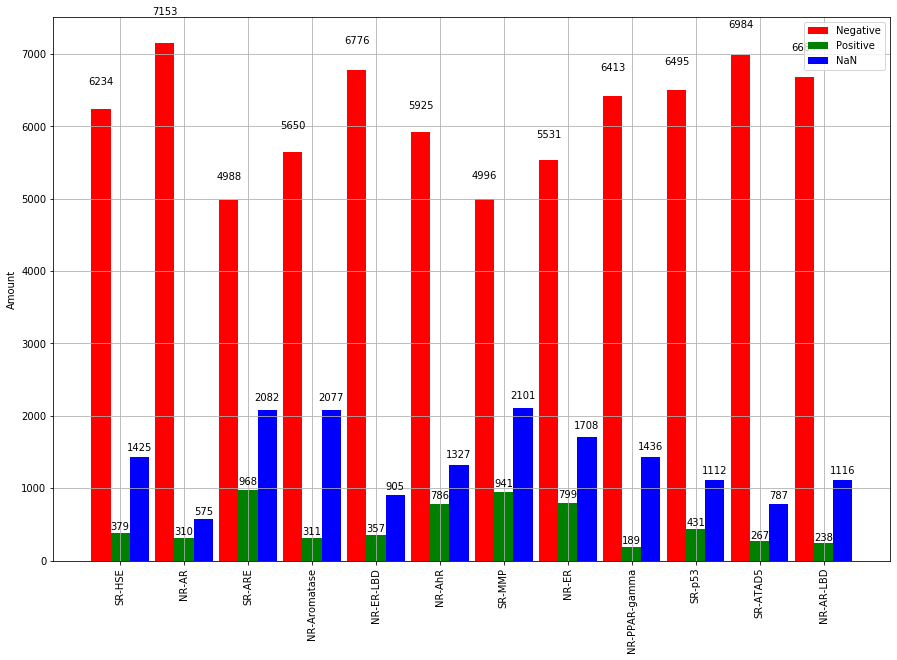

In [90]:
counter_plot(target)

In [91]:
perc_of_pos(target)

SR-ARE           0.120428
SR-MMP           0.117069
NR-ER            0.099403
NR-AhR           0.097786
SR-p53           0.053620
SR-HSE           0.047151
NR-ER-LBD        0.044414
NR-Aromatase     0.038691
NR-AR            0.038567
SR-ATAD5         0.033217
NR-AR-LBD        0.029609
NR-PPAR-gamma    0.023513
dtype: float64

From this we draw two essential conclusions:

1. SR-ARE is the most balanced dataset, but has the largest number of NaN values.
2. NR-AR is the least balanced dataset, but also has the least number of NaN values.

This is an interesting notion, the target data which has the least number of NaNs - thus having the most amount of clear data is the least balanced, thus has the highest capacity to pollute any model. Similarly, the exact opposite exists.


### 4b. Toxicophores

In [92]:
toxicophores.head()

,C1=CC=C(C=C1)N,C1=CC=C(C=C1)CBr,C1=CC=C(C=C1)CI,C1=CC=C(C=C1)CCl,C1=CC=C(C=C1)CF,CNN,C1=CC=C(C=C1)[N+](=O)[O-],NN=O,C1=CC=C2C(=C1)C=CC3=CC=CC=C32,C1=CC(=O)C=CC1=O,C(CCl)SCCCl,C(=S)(N)N
0,0.178571,0.166667,0.166667,0.166667,0.166667,0.000000,0.193548,0.000000,0.312500,0.075472,0.000000,0.000000
1,0.191781,0.181818,0.181818,0.181818,0.181818,0.000000,0.202532,0.030303,0.197531,0.114286,0.000000,0.000000
2,0.011173,0.032787,0.021858,0.032787,0.021858,0.011628,0.021622,0.023256,0.021390,0.000000,0.033708,0.000000
3,0.291667,0.269231,0.269231,0.269231,0.269231,0.000000,0.259259,0.000000,0.178571,0.133333,0.000000,0.048780
4,0.052830,0.081784,0.089219,0.081784,0.081784,0.023256,0.066421,0.007752,0.065934,0.030534,0.007576,0.015504


What is the distribution of similarities

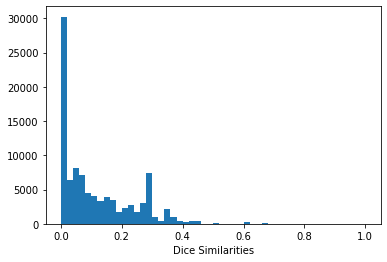

In [94]:
data = toxicophores 
data = data.values.reshape(-1,1).ravel()

vals = plt.hist(data,bins = 50)
plt.xlabel('Dice Similarities')
plt.show()

So, a very large proportion of the candidate molecules have little to no similarity with known toxicophores, however, some still do - indeed a a smallar amount have strong similarities with some of the known toxicophores - let's investigate these further.

Question : How does the larger dice similarity relate to the target variables?

In [95]:
toxicophores['SMILES'] = source_data.loc[toxicophores.index]['SMILES']
molecules = toxicophores.columns

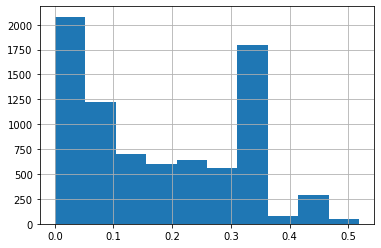

In [96]:
toxicophores[molecules[0]].hist()

In [97]:
molecules = list(molecules)
molecules.remove('SMILES')

Let's go through each molecule and check what the percentage of positive targets when the dice similarities are filteres to be more than half.

In [101]:
res = {}
for mol in molecules:
    idx = toxicophores[mol][toxicophores[mol] > 0.5].index
    target.loc[idx]
    res[mol] = perc_of_pos(target.loc[idx])[:3].to_dict()

In [102]:
pd.DataFrame(res)

,C1=CC=C(C=C1)N,C1=CC=C(C=C1)CBr,C1=CC=C(C=C1)CI,C1=CC=C(C=C1)CCl,C1=CC=C(C=C1)CF,CNN,C1=CC=C(C=C1)[N+](=O)[O-],NN=O,C1=CC=C2C(=C1)C=CC3=CC=CC=C32,C1=CC(=O)C=CC1=O,C(CCl)SCCCl,C(=S)(N)N
NR-AhR,0.347826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.313253,0.285714,NaN,0.333333
SR-ARE,0.282609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.180723,NaN,NaN,NaN
SR-MMP,0.260870,0.386139,0.392157,0.386139,0.386139,NaN,NaN,NaN,NaN,0.285714,NaN,NaN
NR-ER,NaN,0.217822,0.225490,0.217822,0.217822,NaN,NaN,NaN,0.132530,NaN,NaN,NaN
NR-ER-LBD,NaN,0.168317,0.176471,0.168317,0.168317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NR-AR-LBD,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.000000
SR-ATAD5,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
SR-p53,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.285714,0.0,NaN
SR-HSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333
NR-AR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, let's look at the distribution of the postive and negative outcome per target per toxicophore.

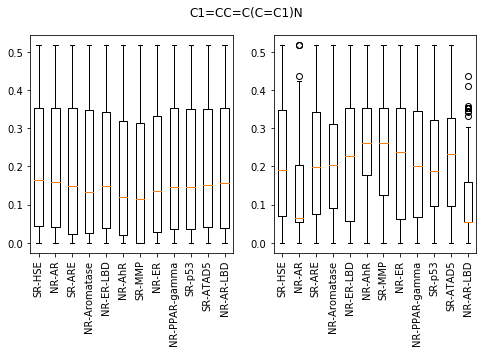

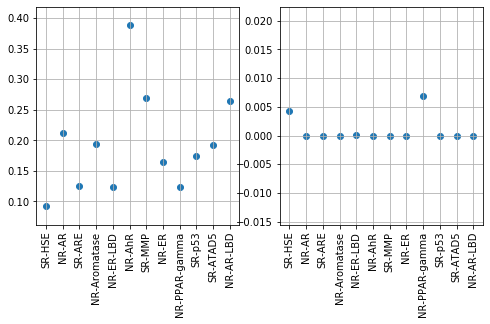

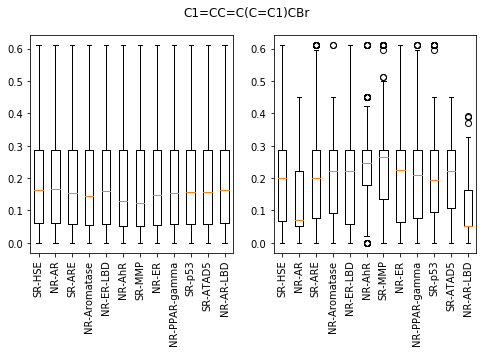

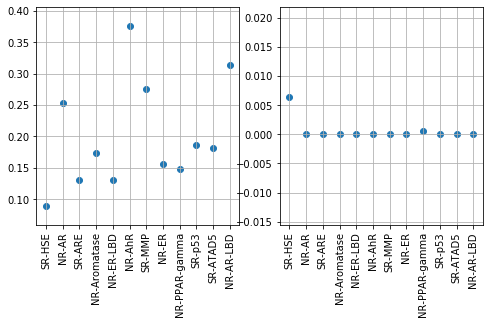

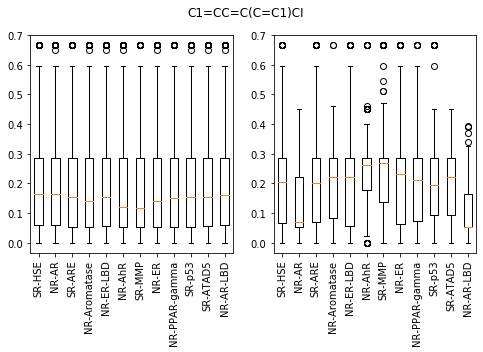

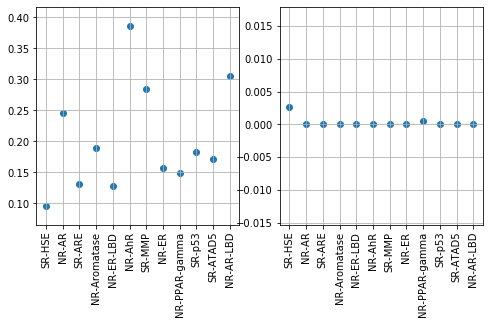

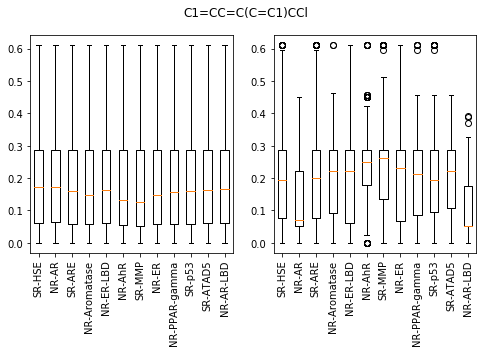

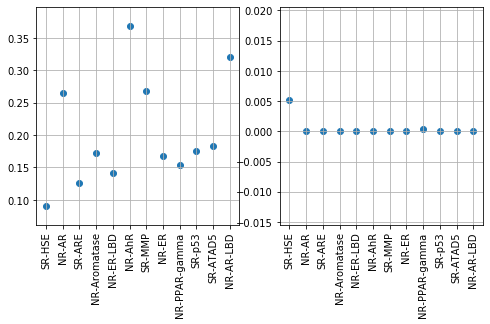

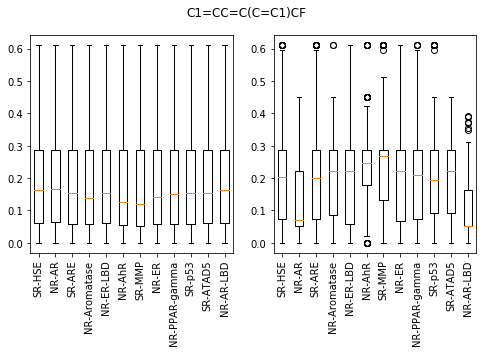

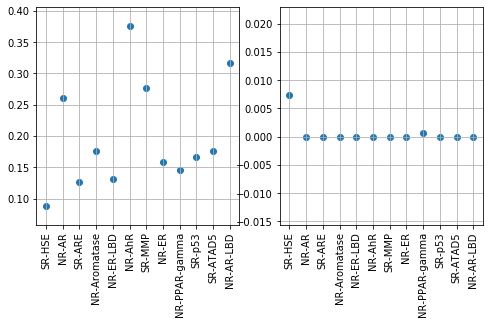

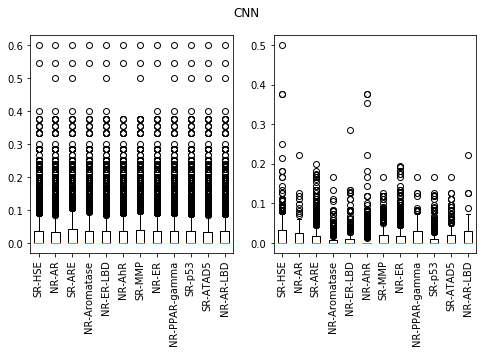

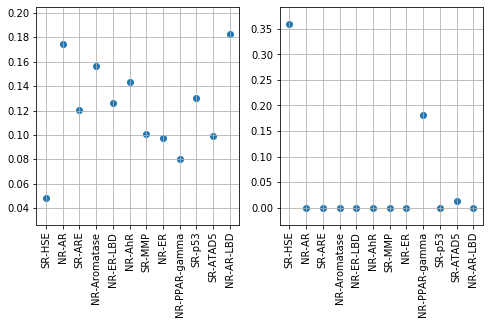

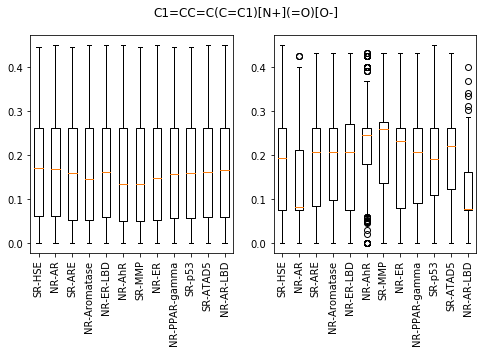

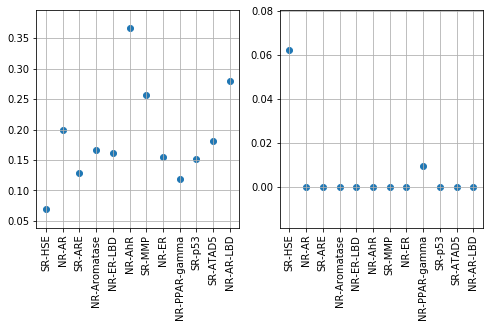

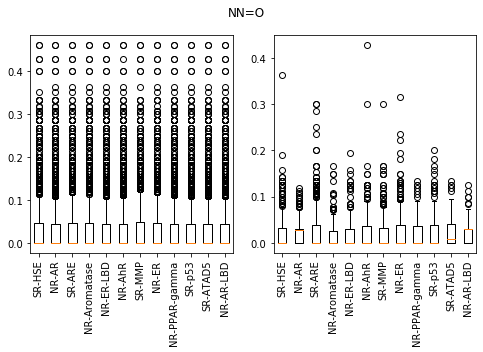

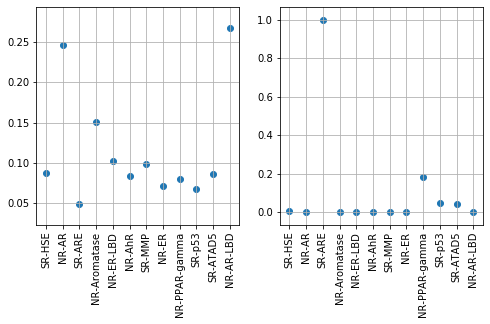

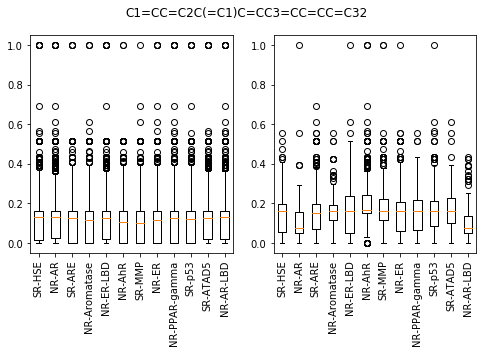

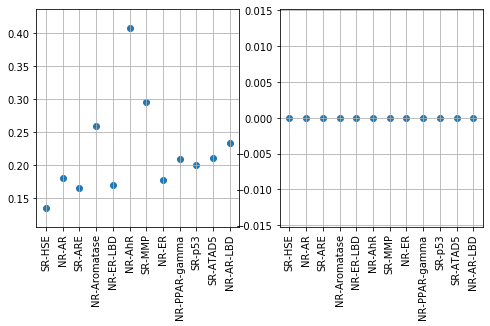

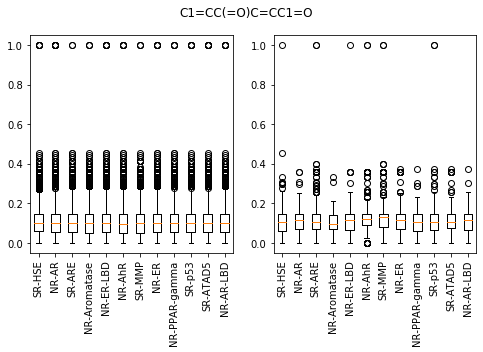

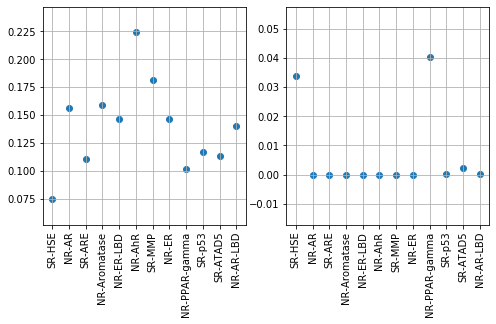

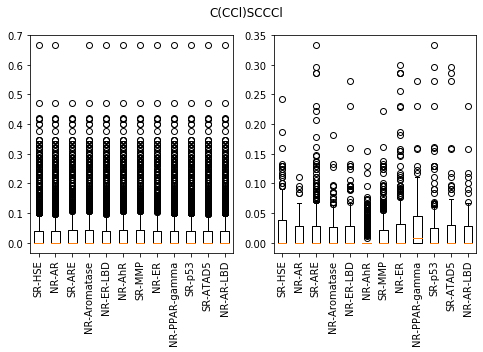

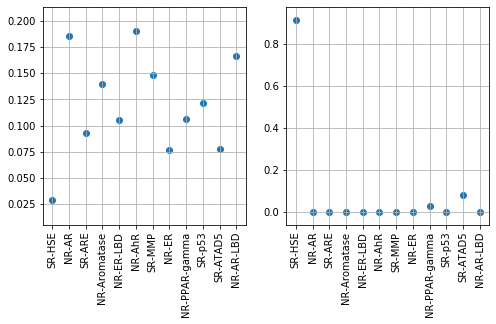

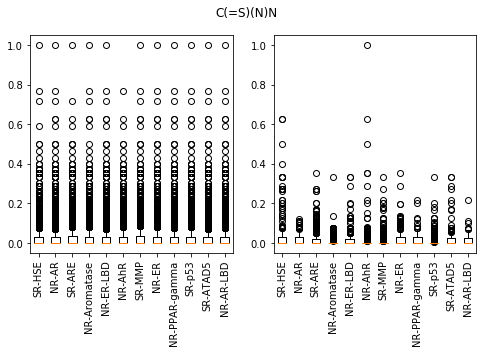

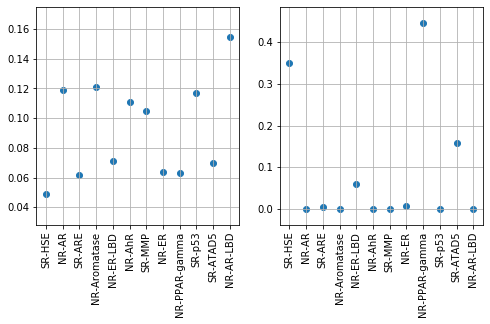

In [105]:
toxicophores_columns = ['C1=CC=C(C=C1)N', 'C1=CC=C(C=C1)CBr', 'C1=CC=C(C=C1)CI','C1=CC=C(C=C1)CCl', \
'C1=CC=C(C=C1)CF', 'CNN','C1=CC=C(C=C1)[N+](=O)[O-]', 'NN=O', 'C1=CC=C2C(=C1)C=CC3=CC=CC=C32',\
'C1=CC(=O)C=CC1=O', 'C(CCl)SCCCl', 'C(=S)(N)N']

for cols in toxicophores_columns:
    box_plot_and_ks_test(cols,toxicophores)

### 4c. Molecular Descriptors

In [107]:
molecular_descriptors.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,...,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000,8038.000000
mean,9.819088,-0.942083,9.820959,0.288912,0.532770,285.330036,267.144404,284.902945,103.130132,0.005474,...,0.039935,0.036203,0.007589,0.005598,0.003981,0.015178,0.001866,0.011819,0.657129,0.027868
std,3.123930,1.681192,3.124195,0.453001,0.194216,172.315245,162.848225,172.138409,63.307387,0.118972,...,0.227559,0.214697,0.090988,0.074617,0.064920,0.133924,0.045954,0.120075,2.314381,0.177690
min,0.000000,-10.657407,0.000000,0.000000,0.008701,30.026000,28.010000,30.010565,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.607073,-1.266644,8.607073,0.029260,0.408604,169.083250,158.092000,168.389115,62.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.633683,-0.456349,10.643981,0.139966,0.538812,247.287000,232.150000,247.046965,88.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11.991530,0.000000,11.991530,0.362130,0.676255,355.379000,333.003500,354.235342,128.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17.442653,2.120000,17.442653,8.764932,0.944994,1950.681000,1904.313000,1949.500417,704.000000,4.000000,...,4.000000,2.000000,2.000000,1.000000,2.000000,4.000000,2.000000,3.000000,35.000000,4.000000


In [109]:
# Let's choose 5 columns with the largest std, as these may have differing behaviour for the different.
cols = list(molecular_descriptors.describe().loc['std'].sort_values()[-5:].index)

descriptor_cols = list(molecular_descriptors.describe().loc['std'].sort_values()[-5:].index)
descriptor_cols

['MolWt', 'Kappa2', 'BertzCT', 'Kappa3', 'Ipc']

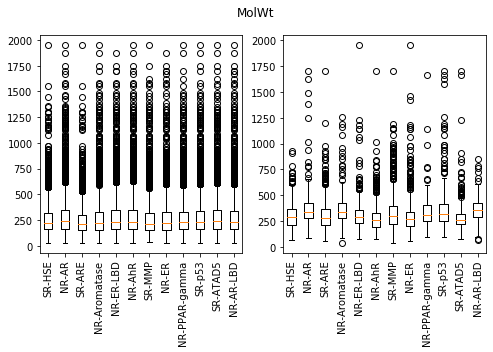

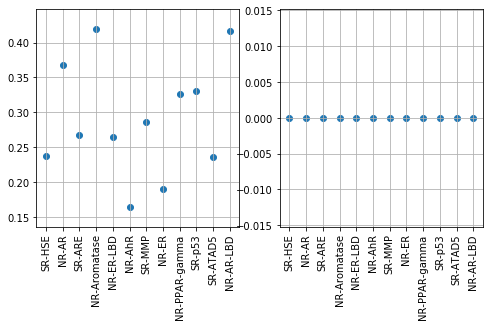

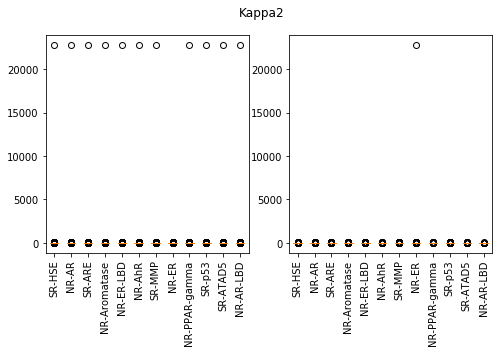

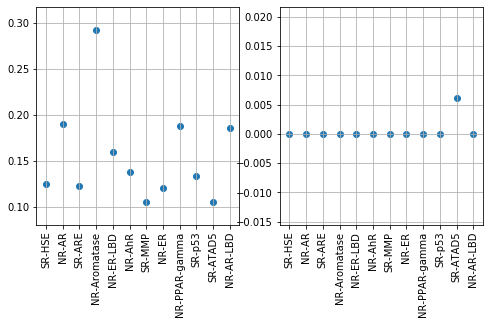

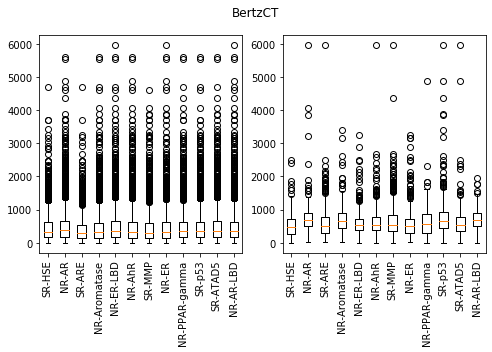

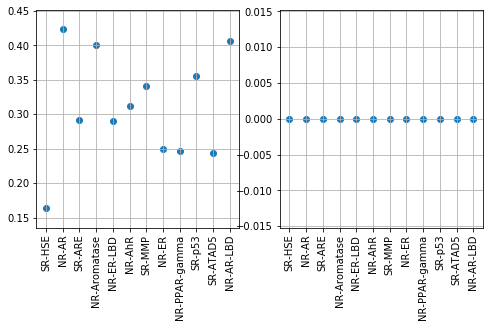

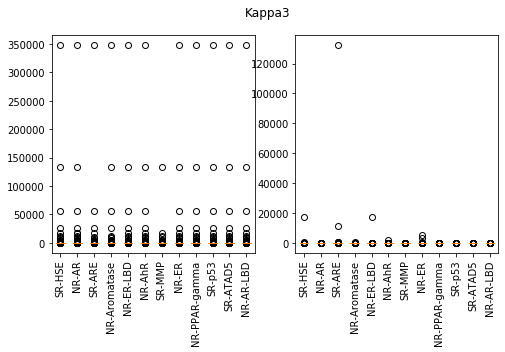

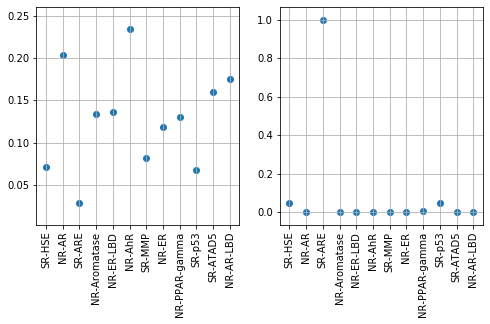

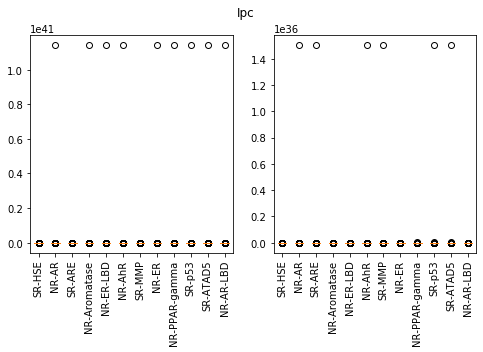

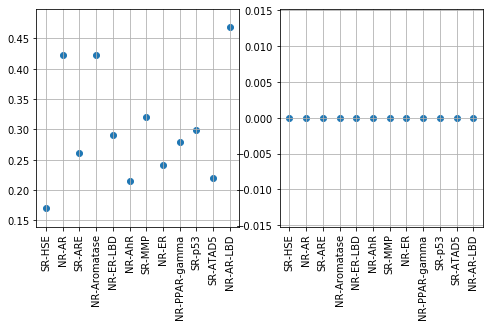

In [110]:
for cols in descriptor_cols:
    box_plot_and_ks_test(cols,molecular_descriptors)

### 4d. Fingerprints

In [111]:
fingerprint.head()

,DSSTox_CID,SMILES,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,...,fp_2039,fp_2040,fp_2041,fp_2042,fp_2043,fp_2044,fp_2045,fp_2046,fp_2047,fp_2048
0,25848,[Cl-].[H]c1c(N([H])[H])c([H])c2c(c1[H])c([H])c...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5234,[H]c1c([H])c([H])c(-c2c3c([H])c(Br)c(=O)c(Br)c...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,28909,[H]O[C@@]1(C([H])([H])[H])O[C@]([H])([C@]2([H]...,1,1,0,0,0,0,0,0,...,1,1,0,0,0,1,1,1,1,0
3,5513,[H]C1=C([H])C(=[N+](C([H])([H])[H])C([H])([H])...,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,26683,[H]N=C(N([H])[H])N([H])C([H])([H])C([H])([H])C...,1,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


How many bit slot are actually occupied, all of them? some of them?

In [112]:
fp_columns = fingerprint.columns
fp_columns = list(fp_columns)
fp_columns.remove('DSSTox_CID')
fp_columns.remove('SMILES')

In [113]:
res = (fingerprint[fp_columns] == 0).all(0)[(fingerprint[fp_columns] == 0).all(0)]
if len(res)==0:
    print('All bits used')
else:
    print('Not all bit used')

All bits used


Let's conside the kmodes clusters for maximally 50 clusters.

WARNING - This takes a very long time to run. Consider taking the saved centroids and clusters rather than rerunning.

In [21]:
from kmodes.kmodes import KModes
data = fingerprint[fp_columns].values
km = KModes(n_clusters=50, init='Random', n_init=5, verbose=1)
clusters = km.fit_predict(data)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3719, cost: 378351.0
Run 1, iteration: 2/100, moves: 2610, cost: 375016.0
Run 1, iteration: 3/100, moves: 1255, cost: 374220.0
Run 1, iteration: 4/100, moves: 662, cost: 374101.0
Run 1, iteration: 5/100, moves: 66, cost: 374101.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5113, cost: 374542.0
Run 2, iteration: 2/100, moves: 1486, cost: 373600.0
Run 2, iteration: 3/100, moves: 384, cost: 373303.0
Run 2, iteration: 4/100, moves: 308, cost: 373137.0
Run 2, iteration: 5/100, moves: 451, cost: 372724.0
Run 2, iteration: 6/100, moves: 543, cost: 372599.0
Run 2, iteration: 7/100, moves: 233, cost: 372531.0
Run 2, iteration: 8/100, moves: 4, cost: 372531.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 4714, cost: 375866.0
Run 3, iteration: 2/100, move

In [22]:
clusters

array([16,  2,  5, ..., 15,  4, 11], dtype=uint16)

In [26]:
km.cluster_centroids_

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

We save the centroids and clusters since they took so very long to find!

In [29]:
np.save('data/fp_clusters.npy',clusters)
np.save('data/fp_centroids.npy', km.cluster_centroids_)

Some of these clusters are are low dimensional - for the purpose of trung to find a patter let us consider only those clusters which have at least 100 items.

In [114]:
#only want to keep those which have at least 100 inputs.
res = {}
for i in range(0,40):
    where = np.where(clusters == i)[0]
    if len(where) >= 100:
        res[i] = where

In [115]:
res.keys()

dict_keys([2, 3, 4, 5, 11, 12, 15, 16, 21, 22, 23, 26, 32, 34, 35, 37])

In [116]:
for v in res.values():
    print(perc_of_pos(target.iloc[v]).sort_values()[-1:].to_dict())

{'NR-AhR': 0.20794392523364486}
{'NR-AhR': 0.1658291457286432}
{'SR-ARE': 0.08591885441527446}
{'NR-AR': 0.3030973451327434}
{'SR-ARE': 0.09425785482123511}
{'NR-ER': 0.1776765375854214}
{'SR-ARE': 0.06988188976377953}
{'NR-AhR': 0.2558139534883721}
{'SR-MMP': 0.10954063604240283}
{'NR-AhR': 0.16346153846153846}
{'SR-MMP': 0.3076923076923077}
{'SR-MMP': 0.365296803652968}
{'NR-AhR': 0.14012738853503184}
{'NR-AhR': 0.2}
{'NR-AhR': 0.1870967741935484}
{'NR-AhR': 0.14864864864864866}


Unfortunately, whilst there is a common subset of targets that appears to be well represented by the clusters, they are not distinguished clearly by the existence of the clusters. 

Finally, we can also check the chi2 statistic and p-value for each of the targets against the subset of candidates of molecules for each cluster.

Recall that the null hypothesis of the chi2 test (from sklearn) is that the two distributions are associated, the null hypothesis is rejected if the p-value > 0.05.

In [193]:
from sklearn.feature_selection import chi2

#e.g.

X1 = np.random.randint(0,10,10)
X2 = np.random.randint(0,10,10)
stat, pvalue = chi2(X1.reshape(-1,1),X2.reshape(-1,1))
print('Two random unifrom vectors produce a stat of {} with a pvalue {}'.format(stat, pvalue))
stat, pvalue = chi2(X1.reshape(-1,1),X1.reshape(-1,1))
print('Two vectors which are the same produce a stat of {} with a pvalue {}'.format(stat, pvalue))

Two random unifrom vectors produce a stat of [6.71428571] with a pvalue [0.24277103]
Two vectors which are the same produce a stat of [14.87755102] with a pvalue [0.03760145]


In [194]:
#chi2 measure the association between categorical variables, nul

In [200]:
def find_chi2(target_column:str, cluster):

    # ignore nulls since they corrupt the test
    y_data = target[target_column].iloc[cluster]
    y_data = y_data.dropna()
    y_index = y_data.index
    y_temp = y_data.values

    X_temp = fingerprint[fp_columns].loc[y_index].values

    stat, pvalue = chi2(X_temp, y_temp.reshape(-1,1))
    return stat, pvalue

To get a simple idea of volume : let's count the number of columns that are most associated with target

In [224]:
#set up a report dataframe:
df = pd.DataFrame(np.zeros((len(res.keys()),len(targets))))
df.columns = targets
df.index = list(res.keys())

for targ in tqdm_notebook(targets):
    for k,v in res.items():
        stat, pvalue = find_chi2(targ,v)
        association_count = len(np.array(fp_columns)[pvalue < 0.05])
        df.at[k,targ] = association_count

In [225]:
df

,SR-HSE,NR-AR,SR-ARE,NR-Aromatase,NR-ER-LBD,NR-AhR,SR-MMP,NR-ER,NR-PPAR-gamma,SR-p53,SR-ATAD5,NR-AR-LBD
2,153.0,105.0,250.0,180.0,93.0,220.0,156.0,112.0,204.0,147.0,135.0,151.0
3,166.0,268.0,234.0,443.0,155.0,60.0,251.0,117.0,0.0,270.0,262.0,377.0
4,186.0,120.0,365.0,299.0,271.0,174.0,188.0,113.0,281.0,258.0,213.0,167.0
5,122.0,708.0,210.0,194.0,212.0,92.0,402.0,241.0,170.0,324.0,157.0,566.0
11,192.0,283.0,181.0,96.0,253.0,204.0,223.0,293.0,156.0,270.0,192.0,212.0
12,101.0,100.0,244.0,242.0,109.0,193.0,206.0,74.0,139.0,174.0,160.0,114.0
15,196.0,55.0,197.0,184.0,183.0,277.0,296.0,162.0,81.0,155.0,113.0,132.0
16,180.0,141.0,68.0,165.0,168.0,99.0,71.0,133.0,192.0,191.0,206.0,169.0
21,184.0,151.0,201.0,150.0,225.0,155.0,192.0,131.0,160.0,183.0,74.0,0.0
22,201.0,362.0,241.0,118.0,121.0,64.0,120.0,93.0,98.0,121.0,188.0,64.0


In [235]:
df.max().sort_values()[::-1]

NR-AR            708.0
NR-AR-LBD        566.0
NR-Aromatase     443.0
SR-MMP           402.0
SR-ARE           365.0
SR-ATAD5         334.0
SR-p53           324.0
NR-ER            293.0
NR-PPAR-gamma    281.0
NR-AhR           277.0
NR-ER-LBD        271.0
SR-HSE           252.0
dtype: float64

So we see that the maximum number of associated fingerprint columns is `NR-AR`, at cluster 5.

In [238]:
df.min().sort_values()

NR-PPAR-gamma      0.0
NR-AR-LBD          0.0
NR-AR             44.0
SR-MMP            44.0
NR-ER-LBD         54.0
SR-ARE            55.0
NR-AhR            60.0
NR-ER             74.0
SR-ATAD5          74.0
NR-Aromatase      96.0
SR-HSE           101.0
SR-p53           112.0
dtype: float64

So we see that the minimum number of associated fingerprint columns is `NR-PPAR-gamma` and `NR-AR-LBD`, at cluster 3 and 21 respectively.